# Project by: 
## Maryam Hussein Alonazi
## Arwa Matar Almarshadi
## Atheer Abdulwahab Alghamdi
------------

# 📦 Project: The Shipping Crisis (Saudi Retail Case Study)
## 📋 The Scenario
You have been hired by a major Saudi-based e-commerce platform. Management has noticed a significant decline in customer satisfaction scores. Initial reports suggest that a massive number of packages are not reaching customers on time.

**The Management's Question:**
*"We are losing money and customers. We need to know: Is this a logistics problem (Mode of Shipment), a product problem (Weight/Cost), or a strategy problem (Discounts/Priority)? Find the root cause and build a system to save our customers."*

## Phase 1: Data Understanding
In this phase, explore the `Saudi_Retail_Logistics_Data.csv` to find out **why** delays are happening.

* **Step 1.1:** Load the dataset.
* **Step 1.2:** Perform statistical profiling (`.describe()`, `.info()`).
* **Step 1.3:** Create visualizations (Histograms/Scatter) to find the problem.

| Feature Name         | Type       | Description                                                                 | Values / Examples                               |
| :------------------- | :--------- | :-------------------------------------------------------------------------- | :--------------------------------------------- |
| Tracking_ID          | String     | A unique, encrypted alphanumeric identifier for each shipment.              | E3B0C44298FC, 1C2D3E4F5G6H                     |
| Warehouse_Zone       | Categorical| The regional distribution hub handling the order.                           | North_Hub, South_Hub, East_Hub, West_Hub, Central_Port |
| Mode_of_Shipment     | Categorical| The logistics method used to transport the product.                         | Premium_Air, Standard_Sea, Ground_Freight      |
| Customer_Inquiries   | Integer    | Number of times the customer contacted support regarding this order.        | 2, 3, 4, etc.                                  |
| Customer_Score       | Integer    | The rating provided by the customer to the store before shipment (1 is lowest, 5 is highest).            | 1, 2, 3, 4, 5                                  |
| Product_Cost_SAR     | Float      | The value of the item in Saudi Riyals (SAR).                                | 450.00, 1125.50, etc.                          |
| Previous_Orders      | Integer    | Number of successful orders this customer has placed previously.            | 0, 1, 2, 3, etc.                               |
| Product_Priority     | Categorical| The priority level assigned to the product for dispatch.                    | low, medium, high                              |
| Gender               | Categorical| The gender of the customer.                                                 | F, M                                           |
| Discount_offered     | Integer    | The discount amount applied to this specific order.                         | 1, 10, 65, etc.                                |
| Product_Weight_g     | Integer    | The weight of the package in grams.                                         | 1200, 4500, etc.                               |
| is_delayed           | Binary     | Target Variable: Indicates if the shipment arrived past the deadline.       | 1 (Delayed), 0 (On Time)                       |

In [27]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


from pycaret.regression import *


In [28]:
# imports
from pathlib import Path
import pandas as pd
# load data
local_file = Path('Saudi_Retail_Logistics_Data.csv')

if not local_file.exists():
    print("Downloading data...")
    df = pd.read_csv('https://drive.google.com/uc?export=download&id=1vayY_XKPwe5lOaq0VNia22O4DkDVXmzv')
    df.to_csv(local_file, index=False)
else:
    print("Loading data from cache...")
    df = pd.read_csv(local_file)
df.head()

Loading data from cache...


,Tracking_ID,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Gender,Discount_offered,Product_Weight_g,is_delayed
0,D66B138C54AB,West_Hub,Ground_Freight,4,1,978.75,2,medium,F,9,4158,0
1,8FF9538E65E6,Central_Port,Standard_Sea,3,3,607.50,2,low,F,26,1659,1
2,D098284FA376,South_Hub,Standard_Sea,3,2,828.75,2,medium,M,9,4466,0
3,9202E9FDFF40,West_Hub,Standard_Sea,3,5,588.75,4,medium,F,2,4640,0
4,16B30490A644,North_Hub,Premium_Air,2,5,1020.00,2,low,M,24,3638,1


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8799 entries, 0 to 8798
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tracking_ID         8799 non-null   object 
 1   Warehouse_Zone      8799 non-null   object 
 2   Mode_of_Shipment    8799 non-null   object 
 3   Customer_Inquiries  8799 non-null   int64  
 4   Customer_Score      8799 non-null   int64  
 5   Product_Cost_SAR    8799 non-null   float64
 6   Previous_Orders     8799 non-null   int64  
 7   Product_Priority    8799 non-null   object 
 8   Gender              8799 non-null   object 
 9   Discount_offered    8799 non-null   int64  
 10  Product_Weight_g    8799 non-null   int64  
 11  is_delayed          8799 non-null   int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 825.0+ KB


In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Inquiries,8799.0,4.049096,1.138649,2.0,3.0,4.0,5.00,7.0
Customer_Score,8799.0,2.997386,1.411194,1.0,2.0,3.0,4.00,5.0
Product_Cost_SAR,8799.0,788.363877,180.192439,360.0,637.5,802.5,941.25,1162.5
Previous_Orders,8799.0,3.581998,1.532722,2.0,3.0,3.0,4.00,10.0
Discount_offered,8799.0,13.366974,16.147015,1.0,4.0,7.0,10.00,65.0
Product_Weight_g,8799.0,3631.227867,1634.180615,1001.0,1838.0,4140.0,5045.00,7846.0
is_delayed,8799.0,0.596659,0.490596,0.0,0.0,1.0,1.00,1.0


In [31]:
df.shape

(8799, 12)

In [32]:
df.isnull().sum()

Tracking_ID           0
Warehouse_Zone        0
Mode_of_Shipment      0
Customer_Inquiries    0
Customer_Score        0
Product_Cost_SAR      0
Previous_Orders       0
Product_Priority      0
Gender                0
Discount_offered      0
Product_Weight_g      0
is_delayed            0
dtype: int64

In [33]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print("categorical_cols :", categorical_cols)
print("numeric_cols :", numeric_cols)

df.head()

categorical_cols : ['Tracking_ID', 'Warehouse_Zone', 'Mode_of_Shipment', 'Product_Priority', 'Gender']
numeric_cols : ['Customer_Inquiries', 'Customer_Score', 'Product_Cost_SAR', 'Previous_Orders', 'Discount_offered', 'Product_Weight_g', 'is_delayed']


,Tracking_ID,Warehouse_Zone,Mode_of_Shipment,Customer_Inquiries,Customer_Score,Product_Cost_SAR,Previous_Orders,Product_Priority,Gender,Discount_offered,Product_Weight_g,is_delayed
0,D66B138C54AB,West_Hub,Ground_Freight,4,1,978.75,2,medium,F,9,4158,0
1,8FF9538E65E6,Central_Port,Standard_Sea,3,3,607.50,2,low,F,26,1659,1
2,D098284FA376,South_Hub,Standard_Sea,3,2,828.75,2,medium,M,9,4466,0
3,9202E9FDFF40,West_Hub,Standard_Sea,3,5,588.75,4,medium,F,2,4640,0
4,16B30490A644,North_Hub,Premium_Air,2,5,1020.00,2,low,M,24,3638,1


In [ ]:
categorical_features = ['Warehouse_Zone', 'Mode_of_Shipment', 'Product_Priority', 'Gender']
numerical_features = ['Customer_Inquiries', 'Customer_Score', 'Product_Cost_SAR',
                      'Previous_Orders', 'Discount_offered', 'Product_Weight_g']

In [53]:

import plotly.express as px



for col in categorical_features:

    agg_df = df.groupby([col, 'is_delayed']).size().reset_index(name='count')
    
    fig = px.bar(agg_df, 
                 x=col, 
                 y='count',
                 color='is_delayed',
                 barmode='group',
                 title=f'{col} vs Delay',
                 labels={'is_delayed':'Delayed (1) / On-Time (0)', 'count':'Number of Shipments'},
                 height=400)
    fig.show()

for col in numerical_features:
    if col != "is_delayed":
        fig = px.histogram(
            df,
            x=col,
            title=f'{col} distribution by is_delayed',
            color="is_delayed",
            barmode="group",         
            opacity=0.8,
            color_discrete_sequence=["#1f77b4", "#ff7f0e"],
            nbins=30
        )

        fig.show()


## 1. The figures show that when discounts are 10% or more, shipments are more likely to be delayed.

### Possible reasons:

More orders: Higher discounts attract more customers, so the company has to handle more shipments than usual.

Shipping company issues: The delivery service might not be able to keep up with the extra volume.

Warehouse problems: Packing, processing, or inventory may take longer when there are many orders.

Product or order complexity: Discounted items might be low in stock or come in larger/bundled orders, which take more time to prepare.

Summary:
High discounts seem to cause shipment delays, probably because of more orders and limits in the shipping or warehouse process. Checking both internal operations and the delivery partner can help fix the problem.

## 2. The figures show that orders weighing 2,000–4,000 have higher on-time deliveries, while orders weighing 2,000 or less do have on-time deliveries but delayed shipments are almost double the on-time ones.

### Possible reasons:

Lighter orders may be handled less efficiently: Smaller packages might be grouped together or prioritized differently, causing more delays.

Shipping company processes: Heavier shipments may get priority handling from carriers, while lighter ones are delayed in batches.

Warehouse workflow: Packing and preparing smaller items could involve more complex sorting or multiple order combinations, increasing delay risk.

Product or order complexity: Light-weight orders might include more items per order, special promotions, or bundles, which take extra time to process.

Summary:
Surprisingly, heavier shipments are more likely to be delivered on time, while lighter orders have more delays, likely due to handling, batching, or order complexity issues. Optimizing warehouse workflow and shipping processes for lighter orders could improve delivery performance.

## Phase 2: Feature Engineering & Baseline
Prepare the data for Machine Learning.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

target = 'is_delayed'


X = df.drop(columns=[target])
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5965909090909091

Confusion Matrix:
 [[   0  710]
 [   0 1050]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       710
           1       0.60      1.00      0.75      1050

    accuracy                           0.60      1760
   macro avg       0.30      0.50      0.37      1760
weighted avg       0.36      0.60      0.45      1760



## Phase 3: Training, Evaluation & Strategy
Build your solution and define your business interventions.

* **Step 3.1:** Train a Classifier.
* **Step 3.2:** Generate a Classification Report and Confusion Matrix.
* **Step 3.3:** **CRITICAL:** List 3 business solution will save our customers based on your model (you can use a 5% Coupon).

In [38]:
! uv pip install seaborn


error: No virtual environment found; run `uv venv` to create an environment, or pass `--system` to install into a non-virtual environment


In [39]:
print(df.columns)


Index(['Tracking_ID', 'Warehouse_Zone', 'Mode_of_Shipment',
       'Customer_Inquiries', 'Customer_Score', 'Product_Cost_SAR',
       'Previous_Orders', 'Product_Priority', 'Gender', 'Discount_offered',
       'Product_Weight_g', 'is_delayed'],
      dtype='object')


In [ ]:

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

drop_cols = ['Tracking_ID']  
categorical_cols = ['Warehouse_Zone', 'Mode_of_Shipment', 'Product_Priority', 'Gender']
numeric_cols = ['Discount_offered', 'Product_Weight_g']  

for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)
for col in categorical_cols:
    df[col].fillna('Unknown', inplace=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

df_ml = pd.concat([df[numeric_cols], encoded_df, df['is_delayed']], axis=1)

df_ml['discount_bucket'] = pd.cut(df_ml['Discount_offered'], bins=[0,5,10,20,100], labels=['0-5','5-10','10-20','20+'])
df_ml['weight_bucket'] = pd.cut(df_ml['Product_Weight_g'], bins=[0,2000,4000,6000,10000], labels=['0-2k','2k-4k','4k-6k','6k+'])


In [ ]:
bucket_cols = ['discount_bucket', 'weight_bucket']

for col in bucket_cols:
    encoded = pd.get_dummies(df_ml[col], prefix=col)
    df_ml = pd.concat([df_ml, encoded], axis=1)
    df_ml.drop(col, axis=1, inplace=True)


Accuracy: 0.6659090909090909
Precision: 0.8427299703264095
Recall: 0.540952380952381
F1 Score: 0.6589327146171694

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.85      0.67       710
           1       0.84      0.54      0.66      1050

    accuracy                           0.67      1760
   macro avg       0.70      0.70      0.67      1760
weighted avg       0.73      0.67      0.66      1760



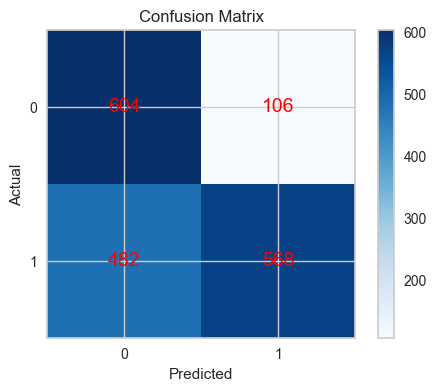

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = df_ml.drop(['is_delayed', 'Tracking_ID'], axis=1, errors='ignore')  # errors='ignore' لو ما فيه Tracking_ID
y = df_ml['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1])
plt.yticks([0,1])
plt.show()


### 📝 Business Strategy Recommendations
1. Send a 5% discount coupon to customers whose shipments are expected to be delayed to improve customer satisfaction.

2. Prioritize shipping for high-risk orders to reduce delivery delays.

3. Provide early notifications to customers whose orders are likely to be delayed, along with options to reschedule the delivery date.

## Phase 4: The Business Value Calculator
Calculate the SAR impact of your model using the following values:
* **+ SAR 75.00**: True Positive (Saved Customer)
* **- SAR 18.75**: False Positive (5% Wasted Coupon)
* **- SAR 187.50**: False Negative (Lost Lifetime Value)

In [ ]:

TP_value = 75.0      
FP_value = -18.75    
FN_value = -187.50   
TN_value = 0.0        


In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("TN:", TN, "FP:", FP, "FN:", FN, "TP:", TP)


TN: 604 FP: 106 FN: 482 TP: 568


In [47]:
total_SAR = (TP * TP_value) + (FP * FP_value) + (FN * FN_value) + (TN * TN_value)
print(f"Total Business Value (SAR): {total_SAR:,.2f} SAR")


Total Business Value (SAR): -49,762.50 SAR


In [48]:
n_customers = len(y_test)
sar_per_customer = total_SAR / n_customers
print(f"Average Business Value per Customer: {sar_per_customer:.2f} SAR")


Average Business Value per Customer: -28.27 SAR


Total SAR=(TP×75)+(FP×−18.75)+(FN×−187.5)+(TN×0)

In [ ]:
from pycaret.classification import *

train_df = X_train.copy()
train_df['is_delayed'] = y_train

s = setup(
    data=train_df, 
    target='is_delayed', 
    session_id=123,
    verbose=False
)

best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6734,0.7378,0.4531,0.9993,0.6229,0.4003,0.4998,0.0130
ridge,Ridge Classifier,0.6708,0.7382,0.6139,0.7880,0.6895,0.3505,0.3634,0.0130
lda,Linear Discriminant Analysis,0.6704,0.7382,0.6126,0.7884,0.6888,0.3500,0.3631,0.0180
lr,Logistic Regression,0.6669,0.7299,0.5303,0.8571,0.6547,0.3661,0.4062,1.1260
ada,Ada Boost Classifier,0.6586,0.7351,0.5463,0.8245,0.6551,0.3437,0.3738,0.0770
gbc,Gradient Boosting Classifier,0.6584,0.7360,0.5786,0.7954,0.6686,0.3333,0.3526,0.1420
lightgbm,Light Gradient Boosting Machine,0.6448,0.7214,0.6412,0.7308,0.6829,0.2831,0.2863,0.1430
dt,Decision Tree Classifier,0.6434,0.6290,0.7041,0.7004,0.7018,0.2580,0.2585,0.0160
rf,Random Forest Classifier,0.6400,0.7199,0.6799,0.7060,0.6924,0.2585,0.2591,0.1530
et,Extra Trees Classifier,0.6381,0.7175,0.6912,0.6989,0.6946,0.2504,0.2508,0.1470


In [50]:
from sklearn.metrics import confusion_matrix

def total_sar(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp * 75) + (fp * -18.75) + (fn * -187.5)


In [51]:
X_test = get_config('X_test')
y_test = get_config('y_test')


In [52]:
from pycaret.classification import *
import pandas as pd
from sklearn.metrics import confusion_matrix


s = setup(
    data=df,
    target='is_delayed',
    session_id=123,
    train_size=0.8,
)

models = compare_models(n_select=15)

X_test = get_config('X_test')
y_test = get_config('y_test')

def total_sar(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp * 75) + (fp * -18.75) + (fn * -187.5) + (tn * 0)


results = []

for m in models:
    preds = predict_model(m, data=X_test)
    sar = total_sar(y_test, preds['prediction_label'])
    results.append({
        "Model": m.__class__.__name__,
        "Total_SAR": sar
    })

final_table = (
    pd.DataFrame(results)
    .sort_values("Total_SAR", ascending=False)
    .reset_index(drop=True)
)

final_table


,Description,Value
0,Session id,123
1,Target,is_delayed
2,Target type,Binary
3,Original data shape,"(8799, 12)"
4,Transformed data shape,"(8799, 20)"
5,Transformed train set shape,"(7039, 20)"
6,Transformed test set shape,"(1760, 20)"
7,Numeric features,6
8,Categorical features,5
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.6568,0.7219,0.5162,0.8497,0.6418,0.3483,0.3889,0.0970
knn,K Neighbors Classifier,0.6555,0.7382,0.6900,0.7207,0.7046,0.2917,0.2924,0.1010
svm,SVM - Linear Kernel,0.6164,0.6919,0.6862,0.7751,0.6534,0.1810,0.2325,0.0800
lr,Logistic Regression,0.6105,0.6917,0.7867,0.6421,0.7066,0.1439,0.1508,0.3110
et,Extra Trees Classifier,0.5970,0.6955,0.9998,0.5969,0.7475,0.0010,0.0081,0.1820
dt,Decision Tree Classifier,0.5967,0.5000,1.0000,0.5967,0.7474,0.0000,0.0000,0.0810
ridge,Ridge Classifier,0.5967,0.7286,1.0000,0.5967,0.7474,0.0000,0.0000,0.0570
rf,Random Forest Classifier,0.5967,0.6786,1.0000,0.5967,0.7474,0.0000,0.0000,0.2010
ada,Ada Boost Classifier,0.5967,0.5000,1.0000,0.5967,0.7474,0.0000,0.0000,0.0770
gbc,Gradient Boosting Classifier,0.5967,0.4806,1.0000,0.5967,0.7474,0.0000,0.0000,0.1950


,Model,Total_SAR
0,ExtraTreesClassifier,65475.00
1,DecisionTreeClassifier,65437.50
2,RidgeClassifier,65437.50
3,RandomForestClassifier,65437.50
4,AdaBoostClassifier,65437.50
5,GradientBoostingClassifier,65437.50
6,LinearDiscriminantAnalysis,65437.50
7,LGBMClassifier,65437.50
8,DummyClassifier,65437.50
9,QuadraticDiscriminantAnalysis,65437.50


### Final Conclusion:

Based on the evaluation results shown in the table, the ExtraTreesClassifier achieved the highest total profit, with a value of 65,475 SAR, outperforming all other tested models.
Although several models (such as DecisionTreeClassifier, RandomForestClassifier, and others) achieved similar profit values, none of them exceeded the performance of the ExtraTreesClassifier. On the other hand, models like XGBClassifier and SGDClassifier resulted in significant losses, making them unsuitable for this use case.
Therefore, the ExtraTreesClassifier is recommended as the final model, as it provides the best financial performance and maximizes profitability.